# SWOT Lofoten Eddy 09/05/2025

In [1]:
import xarray as xr
import shapefile as shp 
import numpy as np
import matplotlib.pyplot as plt
import SWOT_tools as st
import pandas as pd
from shapely.geometry import box
from shapely.wkt import loads  # In case your polygons are stored as WKT strings
import scipy 
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches
from datetime import datetime
from tqdm import tqdm
import os

#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})

In [2]:
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})

import matplotlib.font_manager as fm
# Regular and bold font paths
font_regular_path = "fonts/times/times.ttf"
font_bold_path = "fonts/times/timesbd.ttf"  # Bold
# Register both fonts
fm.fontManager.addfont(font_regular_path)
fm.fontManager.addfont(font_bold_path)
# Create font properties
font_regular = fm.FontProperties(fname=font_regular_path)
font_bold = fm.FontProperties(fname=font_bold_path)
# Set default font to regular Times New Roman
plt.rcParams['font.family'] = font_regular.get_name()

In [3]:
sar_file_root = r"data/iw/l2/"
swot_root = r"data/swot/"


### Selection of the desired case ###

#year_and_day = "2023/270/"
#year_and_day = "2024/142/"
#year_and_day = "2024/211/"
#year_and_day = "2024/295/"
#year_and_day = "2024/304/"
year_and_day = "2025/129/"

sar_file_root += year_and_day
swot_root += year_and_day




dx (km): 467.30, dy (km): 555.97, scale: 1.19


100%|██████████| 3/3 [00:00<00:00, 220.25it/s]

100%|██████████| 3/3 [00:00<00:00, 221.98it/s]

100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


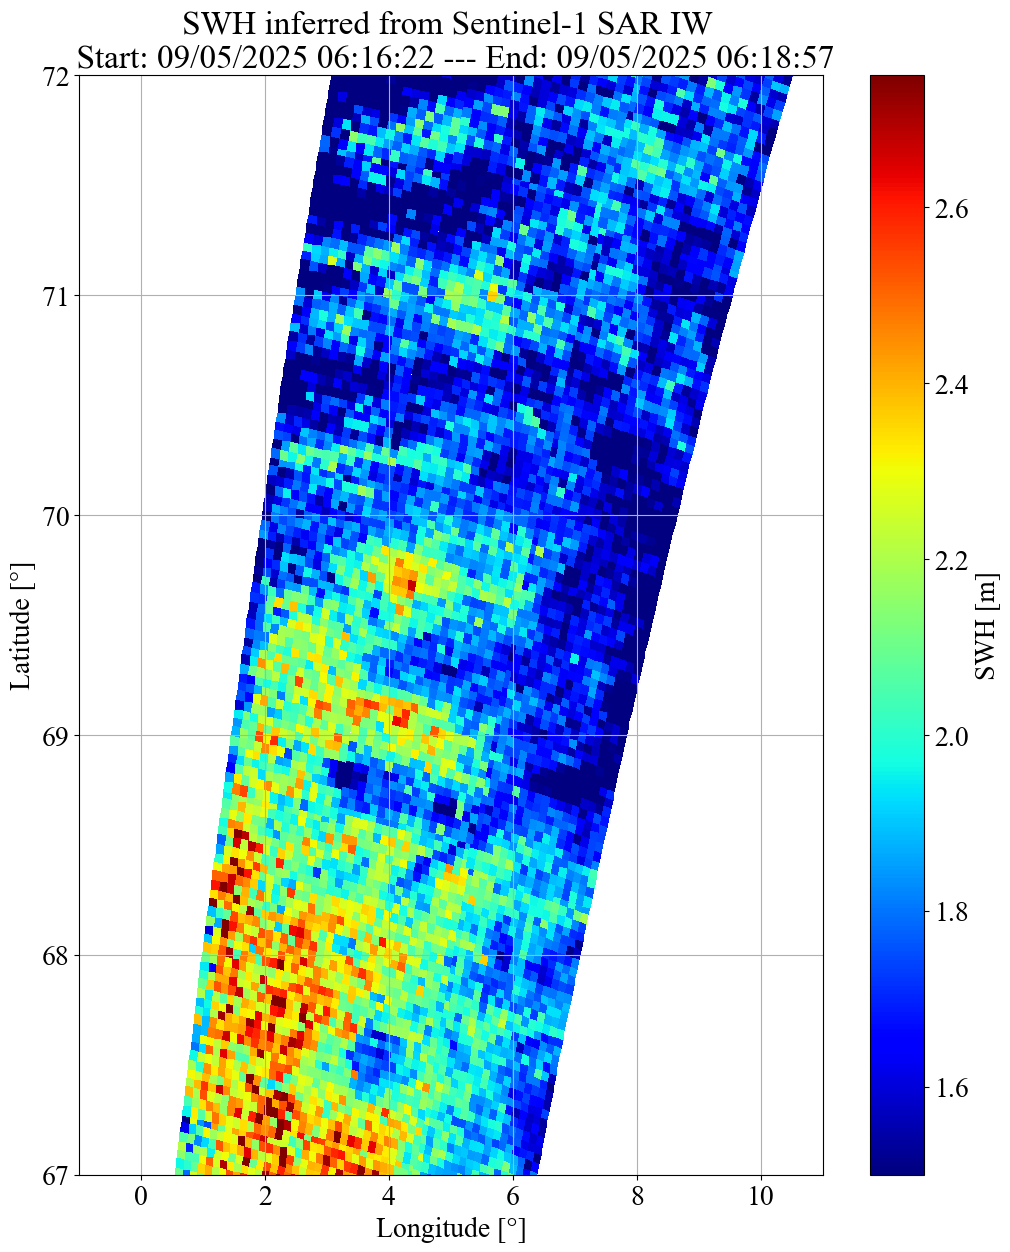

In [4]:
lon_map_min, lon_map_max, lat_map_min, lat_map_max = -1, 11, 67, 72
Lx, Ly = st.geoscale_fig(lon_map_min, lon_map_max, lat_map_min, lat_map_max, Lx=6)
plt.rcParams.update({'font.size': 20})  
iw_files = {"iw1": None, "iw2": None, "iw3": None}
plt.figure(figsize=(Lx, Ly))
plt.xlim(lon_map_min, lon_map_max)
plt.ylim(lat_map_min, lat_map_max)

dt_ini_min =  datetime.strptime("20310927T163757", "%Y%m%dT%H%M%S") # 2031 pour être sûr qu'il sera jamais pris en date de début
dt_end_max =  datetime.strptime("20010927T163857", "%Y%m%dT%H%M%S") # 2001 pour être sûr qu'il sera jamais pris en date de fin

lon_map_min, lon_map_max = 180, -180 # valeurs extrêmes exprès pour que ça se mette bien
lat_map_min, lat_map_max = 90, -90

HSML_gro_array = np.array([])
lon_hsml_gro_array = np.array([])
lat_hsml_gro_array = np.array([])

for iw_dir in tqdm(os.listdir(sar_file_root)):    
    for f in os.listdir(sar_file_root + iw_dir):
        if f.endswith(".nc"):
            # On trie pour mettre dans le bon ordre
            for iw_pat in iw_files:
                if iw_pat in f:
                    iw_files[iw_pat] = os.path.join(sar_file_root + iw_dir, f)
                    

    dt_ini = datetime.strptime(iw_files["iw1"][37:52], "%Y%m%dT%H%M%S")
    if dt_ini < dt_ini_min:
        dt_ini_min = dt_ini

    dt_end = datetime.strptime(iw_files["iw1"][53:68], "%Y%m%dT%H%M%S")
    if dt_end > dt_end_max:
        dt_end_max = dt_end

    ds1 = xr.open_dataset(iw_files["iw1"], group='intraburst') # ds_intra, iw1
    ds2 = xr.open_dataset(iw_files["iw2"], group='intraburst') # ds_intra, iw2
    ds3 = xr.open_dataset(iw_files["iw3"], group='intraburst') # ds_intra, iw3

    ds_list = [ds1, ds2, ds3]
    
    for ds in tqdm(ds_list):
        # Si d'aventure un jour c'est trop lent, on peut tenter la technique de Vadream avec le xr.openmf_dataset ou un truc du style (pour tout avoir d'un coup)
        lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values

        lon_hsml_gro_array = np.concatenate((lon_hsml_gro_array, lon.ravel()))
        lat_hsml_gro_array = np.concatenate((lat_hsml_gro_array, lat.ravel()))
        
        if np.nanmin(lon) < lon_map_min:
            lon_map_min = np.nanmin(lon)
        if np.nanmax(lon) > lon_map_max:
            lon_map_max = np.nanmax(lon)
            
        if np.nanmin(lat) < lat_map_min:
            lat_map_min = np.nanmin(lat)
        if np.nanmax(lat) > lat_map_max:
            lat_map_max = np.nanmax(lat)
        
        hsml = ds.variables["hs_most_likely"].values
        HSML_gro_array = np.concatenate((HSML_gro_array, hsml.ravel()))

        plt.pcolormesh(lon, lat, hsml, cmap="jet",vmin=1.5, vmax=2.75)

    
plt.title("SWH inferred from Sentinel-1 SAR IW \n Start: {} --- End: {}".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S')))
plt.colorbar(label="SWH [m]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.grid()
plt.savefig("output_images/LF/SARWAVE_output.png")
plt.show()

In [5]:
ds_swot_night = xr.open_dataset(r"/home1/datawork/msimonne/LE_20250509/swot/SWOT_L2_LR_SSH_WindWave_032_309_20250509T005653_20250509T014822_PID0_01.nc") 
ds_swot_morning = xr.open_dataset(r"/home1/datawork/msimonne/LE_20250509/swot/SWOT_L2_LR_SSH_WindWave_032_318_20250509T083955_20250509T093123_PID0_01.nc")
ds_swot_morning = xr.open_dataset(r"/home1/datawork/msimonne/LE_20250509/swot/SWOT_L2_LR_SSH_Expert_032_318_20250509T083955_20250509T093123_PID0_01.nc") # fichier EXPERT

ds_swot_night.coords['longitude'] = (ds_swot_night.coords['longitude'] + 180) % 360 - 180
ds_swot_morning.coords['longitude'] = (ds_swot_morning.coords['longitude'] + 180) % 360 - 180

lon_map_min, lon_map_max, lat_map_min, lat_map_max = 1.5, 8, 68.5, 70.5
lon_map_min, lon_map_max, lat_map_min, lat_map_max = 2, 8, 68.75, 70.5
lon_map_min, lon_map_max, lat_map_min, lat_map_max = -1, 11, 67, 72
#lon_map_min, lon_map_max, lat_map_min, lat_map_max = 1.5, 8, 68, 72 
#lon_map_min, lon_map_max, lat_map_min, lat_map_max = -5, 15, 60, 80 

ds_swot_night = ds_swot_night.where((ds_swot_night.longitude >= lon_map_min) & (ds_swot_night.longitude <= lon_map_max) & (ds_swot_night.latitude >= lat_map_min) & (ds_swot_night.latitude <= lat_map_max), drop=True)
ds_swot_morning = ds_swot_morning.where((ds_swot_morning.longitude >= lon_map_min) & (ds_swot_morning.longitude <= lon_map_max) & (ds_swot_morning.latitude >= lat_map_min) & (ds_swot_morning.latitude <= lat_map_max), drop=True)

# Piece of code to recalibrate expert files using Alejandro Bohé's algorithm (cf class_recalibrate_SWH_Expert package)

Expert files are required to do so. This was just a test on the LBE - and it appears that it did not change much the outputs.

In [6]:
#import sys
#sys.path.append(calibration_path)
import class_recalibrate_SWH_Expert

calibration_file = 'data/swot/Expert/gamma_cal_SCIphase.nc'
updater = class_recalibrate_SWH_Expert.SWH_updater(calibration_file)

#%%time
# just an example below; update the path to the product whose SWH you want to update. Note this has to be an Expert product (WindWave will not work)
path_to_Expert_product = r'data/swot/Expert/2025/129/SWOT_L2_LR_SSH_Expert_032_318_20250509T083955_20250509T093123_PID0_01.nc'
expert_ds = xr.open_dataset(path_to_Expert_product)
# Mon filtrage SWOT (cf cellules suivantes)
expert_ds, t_ini_swot_formatted, t_end_swot_formatted = st.format_ds_swot(expert_ds, lon_map_min, lon_map_max, lat_map_min, lat_map_max, untrustable_hs=25, kernel_size_nan=1, step_to_crop_at_edges=2)

for v in expert_ds:
    if 'swh_karin' in v:
        print(v)

swh_karin
swh_karin_qual
swh_karin_uncert
swh_karin_clean_step_1
swh_karin_fully_cleaned


dx (km): 467.30, dy (km): 555.97, scale: 1.19


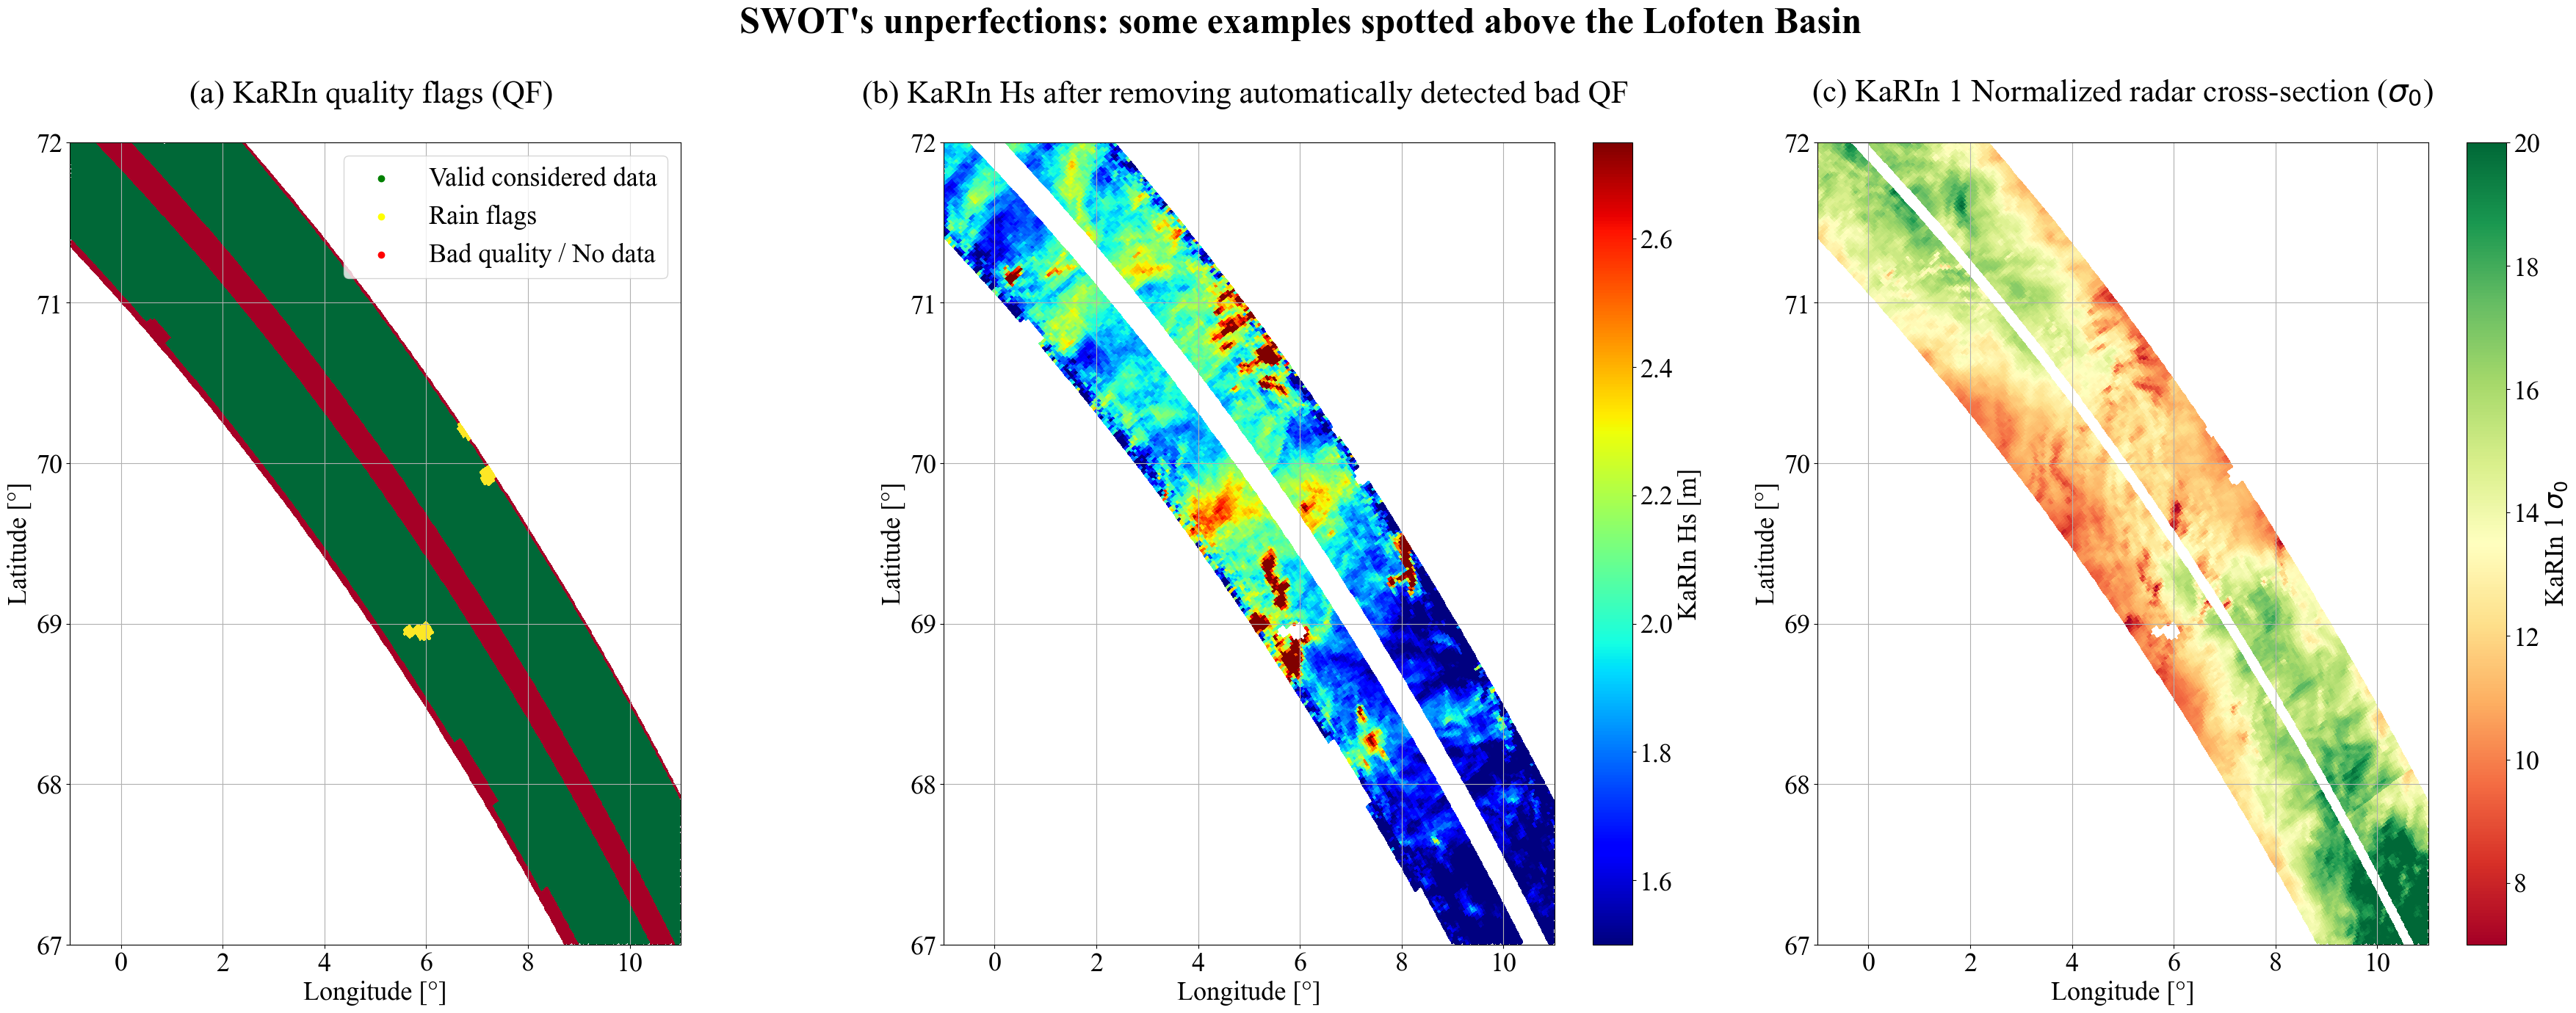

In [7]:
Lx, Ly = st.geoscale_fig(lon_map_min, lon_map_max, lat_map_min, lat_map_max, Lx=4)
plt.rcParams.update({'font.size': 26})  
n_p = 3
fig, ax = plt.subplots(1, n_p, figsize=(n_p*Lx, Ly))

im0 = ds_swot_morning.swh_karin_qual.plot(x="longitude",y="latitude", cmap="RdYlGn_r", add_colorbar=False, ax=ax[0])
ds_rain = ds_swot_morning.where(ds_swot_morning.rain_flag>=0.01)
ds_rain.rain_flag.plot(x="longitude",y="latitude",vmin=0, vmax=2, add_colorbar=False, ax=ax[0])

ax[0].scatter(0,0,color="green", label="Valid considered data")
ax[0].scatter(0,0,color="yellow", label="Rain flags")
ax[0].scatter(0,0,color="red", label="Bad quality / No data")
ax[0].set_title("(a) KaRIn quality flags (QF) \n")
ax[0].legend()

# Create colorbar, but invisible to keep spacing between subplots
cbar = plt.colorbar(im0, ax=ax[0], alpha=0.2)
cbar.ax.clear()                   # wipes the color mesh and ticks
cbar.outline.set_visible(False)
cbar.set_ticks([])           # Remove ticks
cbar.ax.set_xticks([])

ds_swot_morning = ds_swot_morning.where(ds_swot_morning.rain_flag == 0)
im1 = ds_swot_morning.swh_karin.plot(x="longitude",y="latitude", cmap="jet",  add_colorbar=False, ax=ax[1],vmin=1.5, vmax=2.75)
ax[1].set_title("(b) KaRIn Hs after removing automatically detected bad QF \n")
plt.colorbar(im1, label = "KaRIn Hs [m]")

#ds_swot_morning.sig0_karin_qual.plot(x="longitude",y="latitude", cmap="viridis", ax=ax[3])
im2 = ds_swot_morning.sig0_karin.plot(x="longitude",y="latitude", cmap="RdYlGn",  add_colorbar=False, ax=ax[2], vmin=7, vmax=20)
ax[2].set_title(r"(c) KaRIn 1 Normalized radar cross-section ($\sigma_0$)" + "\n")
plt.colorbar(im2, label = r"KaRIn 1 $\sigma_0$")

#im3 = ds_swot_morning.sig0_karin_2.plot(x="longitude",y="latitude", cmap="RdYlGn",  add_colorbar=False, ax=ax[3], vmin=7, vmax=20)
#ax[3].set_title(r"(d) KaRIn 2 Normalized radar cross-section ($\sigma_0$)" + "\n")
#plt.colorbar(im3, label= r"KaRIn 2 $\sigma_0$")
#ds_clean = ds_swot_morning.where(ds_swot_morning.sig0_karin_2 > 11)
#ds_clean.swh_karin.plot(x="longitude",y="latitude", cmap="jet", ax=ax[3],vmin=1.5, vmax=2.75)

#ds_swot, t_ini_swot_formatted, t_end_swot_formatted = st.format_ds_swot(ds_swot_morning, lon_map_min, lon_map_max, lat_map_min, lat_map_max, untrustable_hs=30, kernel_size_nan=1, step_to_crop_at_edges=2)
#ds_swot["swh_karin_fully_cleaned"].plot(x="longitude",y="latitude", cmap="jet", ax=ax[4], vmin=1.5,vmax=2.75)

plt.rcParams.update({'font.size': 36})  
for i in range(n_p):
    ax[i].grid()
    ax[i].set_xlim(lon_map_min, lon_map_max)
    ax[i].set_ylim(lat_map_min, lat_map_max)

    ax[i].set_xlabel("Longitude [°]")
    ax[i].set_ylabel("Latitude [°]")

plt.rcParams.update({'font.size': 26})  

    
plt.suptitle("SWOT's unperfections: some examples spotted above the Lofoten Basin", fontproperties=font_bold, fontsize=36)
plt.tight_layout()
plt.savefig("output_images/LF/SWOT_unperfect.png")
plt.show()


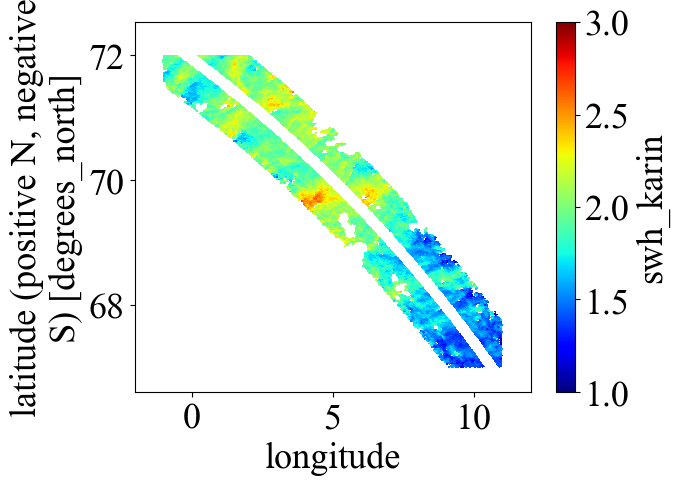

In [8]:
ds_swot_morning = xr.open_dataset(r"data/swot/2025/129/SWOT_L2_LR_SSH_WindWave_032_318_20250509T083955_20250509T093123_PID0_01.nc")
#lon_map_min, lon_map_max, lat_map_min, lat_map_max = -1, 11, 67, 72
ds_swot, t_ini_swot_formatted, t_end_swot_formatted = st.format_ds_swot(ds_swot_morning, lon_map_min, lon_map_max, lat_map_min, lat_map_max, untrustable_hs=25, kernel_size_nan=1, step_to_crop_at_edges=2)

ds_swot.swh_karin.plot(x="longitude", y="latitude", cmap="jet", vmin=1, vmax=3)

dx (km): 467.30, dy (km): 555.97, scale: 1.19


/dev/shm/pbs.3824536.datarmor0/ipykernel_44052/63888181.py:16: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im1, label=r"$\dfrac{\partial H_s}{\partial x}$ [m/km]")
/dev/shm/pbs.3824536.datarmor0/ipykernel_44052/63888181.py:20: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im2, label=r"$\dfrac{\partial H_s}{\partial y}$ [m/km]")


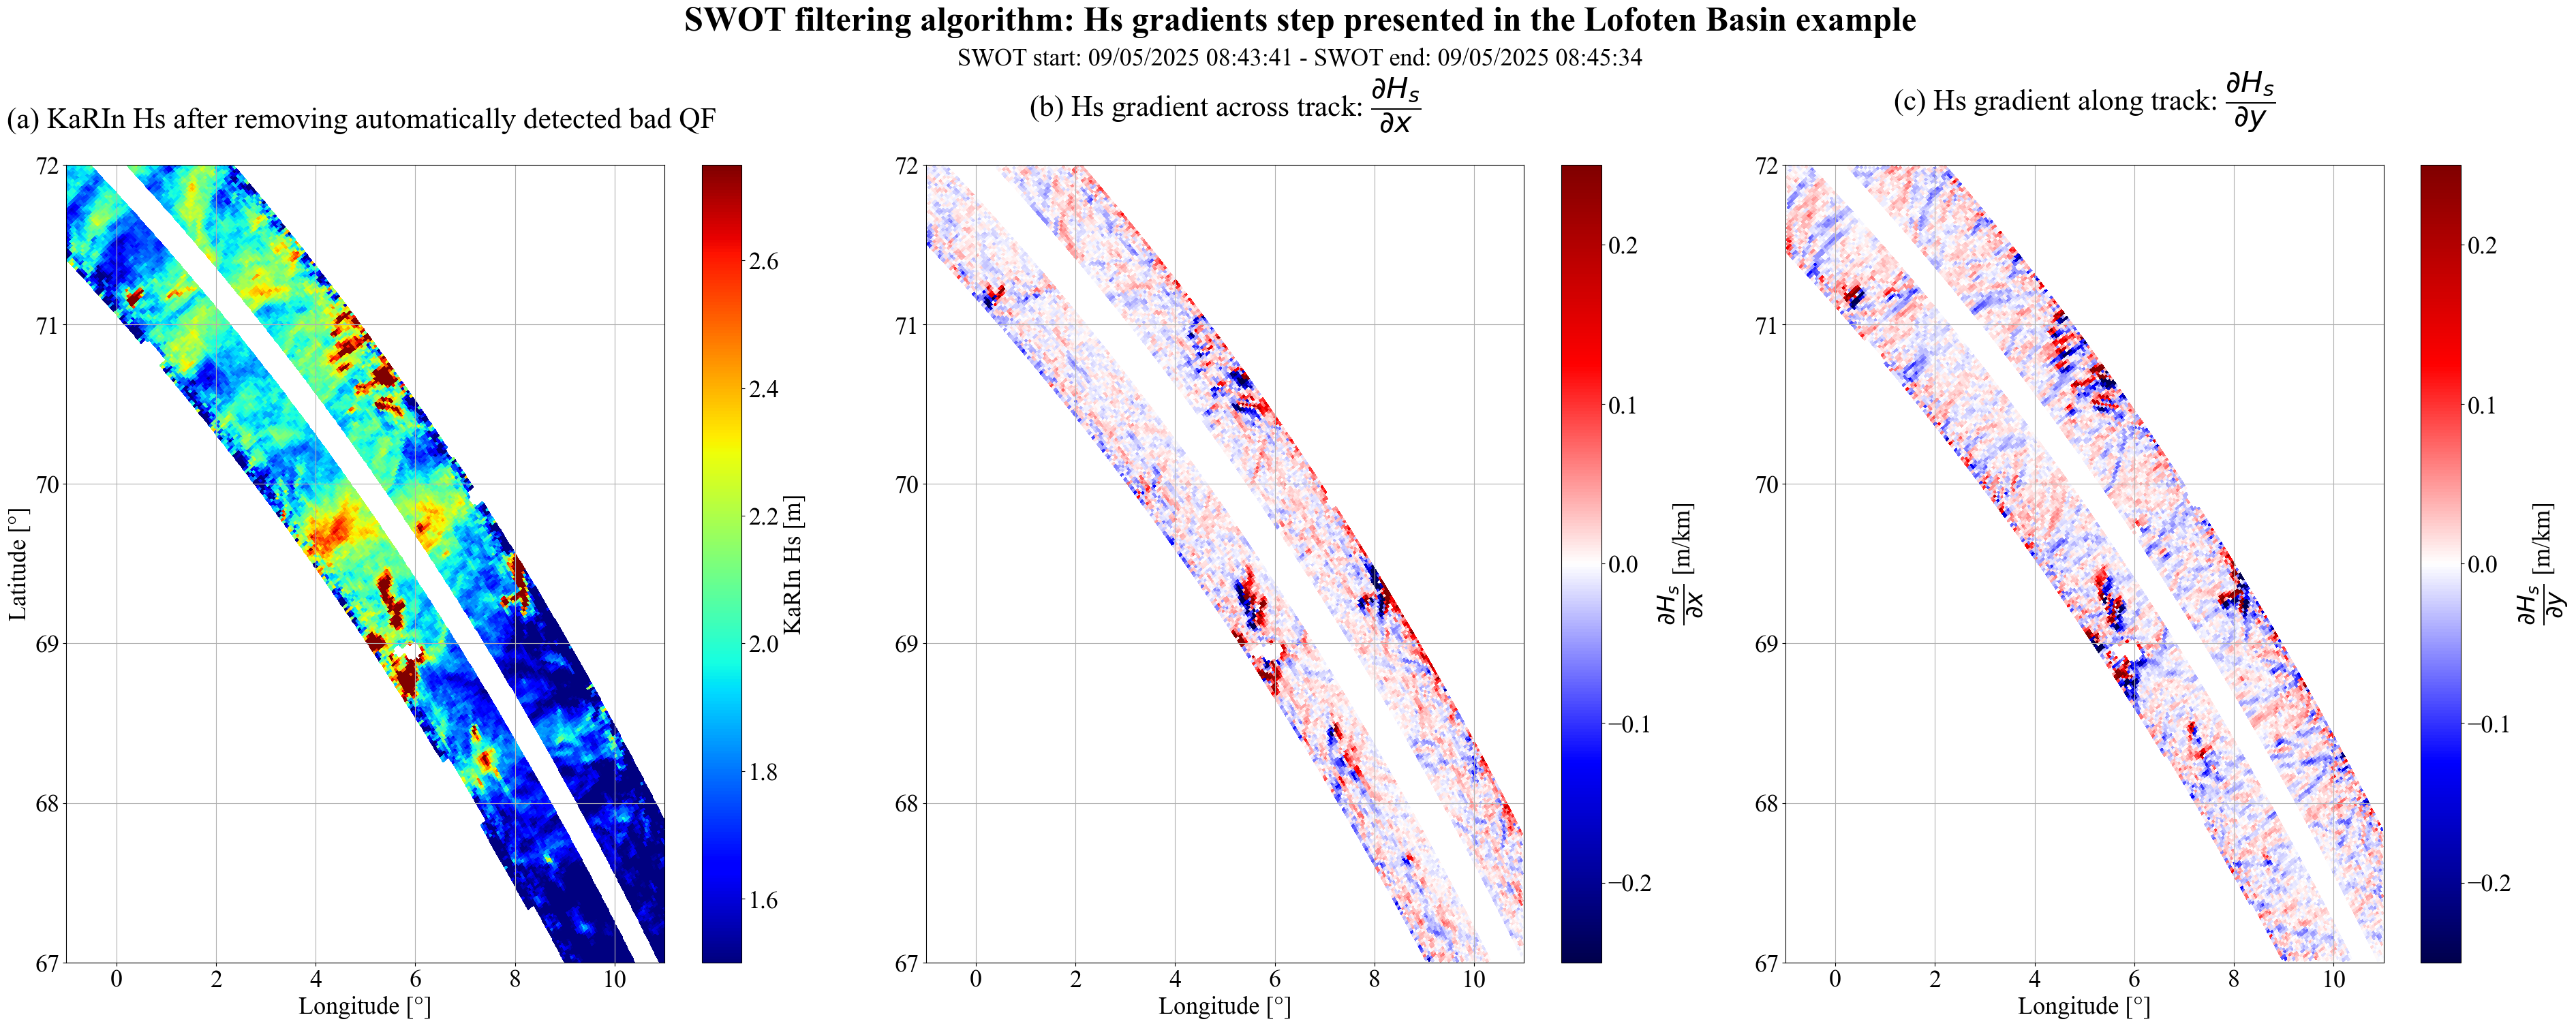

In [9]:
Lx, Ly = st.geoscale_fig(lon_map_min, lon_map_max, lat_map_min, lat_map_max, Lx=4)
show_swot=True
plt.rcParams.update({'font.size': 26})  
lon_swot, lat_swot = ds_swot.longitude, ds_swot.latitude
if show_swot:
    n_p = 3
    fig, ax = plt.subplots(1, n_p, figsize=(1.075*n_p*Lx, 1.09*Ly))

    ds_swot_morning = ds_swot_morning.where(ds_swot_morning.rain_flag == 0)
    im0 = ds_swot_morning.swh_karin.plot(x="longitude",y="latitude", cmap="jet", ax=ax[0], add_colorbar=False, vmin=1.5, vmax=2.75)
    ax[0].set_title("(a) KaRIn Hs after removing automatically detected bad QF \n")
    plt.colorbar(im0, label="KaRIn Hs [m]")
    
    im1 = ax[1].pcolor(lon_swot, lat_swot, ds_swot.dHsdx, cmap="seismic", vmin=-1/4, vmax =1/4)
    ax[1].set_title(r"(b) Hs gradient across track: $\dfrac{\partial H_s}{\partial x}$" + "\n")
    plt.colorbar(im1, label=r"$\dfrac{\partial H_s}{\partial x}$ [m/km]")
    
    im2 = ax[2].pcolor(lon_swot, lat_swot, ds_swot.dHsdy, cmap="seismic", vmin=-1/4, vmax =1/4)
    ax[2].set_title(r"(c) Hs gradient along track: $\dfrac{\partial H_s}{\partial y}$"+ "\n")
    plt.colorbar(im2, label=r"$\dfrac{\partial H_s}{\partial y}$ [m/km]")

    """
    im3 = ax[3].pcolor(lon_swot, lat_swot, swh_karin_clean, cmap="jet", vmin=1.5, vmax =2.75)
    ax[3].set_title("(d) KaRIn Hs - removing untrustable Hs gradients \n")
    plt.colorbar(im3, label="Hs [m]")

    im4 = ax[4].pcolor(lon_swot, lat_swot, swh_karin_clean_encore_plus, cmap="jet", vmin=1.5, vmax =2.75)
    ax[4].set_title('(e) KaRIn Hs - removing Hs "islands" \n')
    plt.colorbar(im4, label="Hs [m]")
    """
    """
    im5 = ax[5].pcolor(lon_swot, lat_swot, swh_karin_clean_sig0, cmap="jet", vmin=1.5, vmax =2.75)
    plt.colorbar(im5, label="Clean Hs [m]")
    ax[5].set_title("Cleaned Hs sig0")

    im6 = ax[6].pcolor(lon_swot, lat_swot, swh_karin_clean_encore_plus_sig0, cmap="jet", vmin=1.5, vmax =2.75)
    plt.colorbar(im6, label="Super clean Hs [m]")
    ax[6].set_title("Super cleaned Hs")
    """
    #ds_swot.swh_karin.plot(x="longitude",y="latitude", cmap="jet", ax=ax[5],vmin=1, vmax=3)

    ax[0].set_ylabel("Latitude [°]")

    for i in range(n_p):
        ax[i].grid()
        ax[i].set_xlim(lon_map_min, lon_map_max)
        ax[i].set_ylim(lat_map_min, lat_map_max)
    
        ax[i].set_xlabel("Longitude [°]")

    fig.suptitle("SWOT filtering algorithm: Hs gradients step presented in the Lofoten Basin example", fontproperties=font_bold, fontsize=36)
    fig.text(x=0.5,y=0.925,s=f"SWOT start: {t_ini_swot_formatted} - SWOT end: {t_end_swot_formatted}", ha="center")
    plt.tight_layout()
    plt.savefig("output_images/LF/SWOT_filtering_grad.png")
    plt.show()
    
        


dx (km): 467.30, dy (km): 555.97, scale: 1.19


/dev/shm/pbs.3824536.datarmor0/ipykernel_44052/488910550.py:28: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im1, label="KaRIn Hs [m]")
/dev/shm/pbs.3824536.datarmor0/ipykernel_44052/488910550.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im2, label="KaRIn Hs [m]")


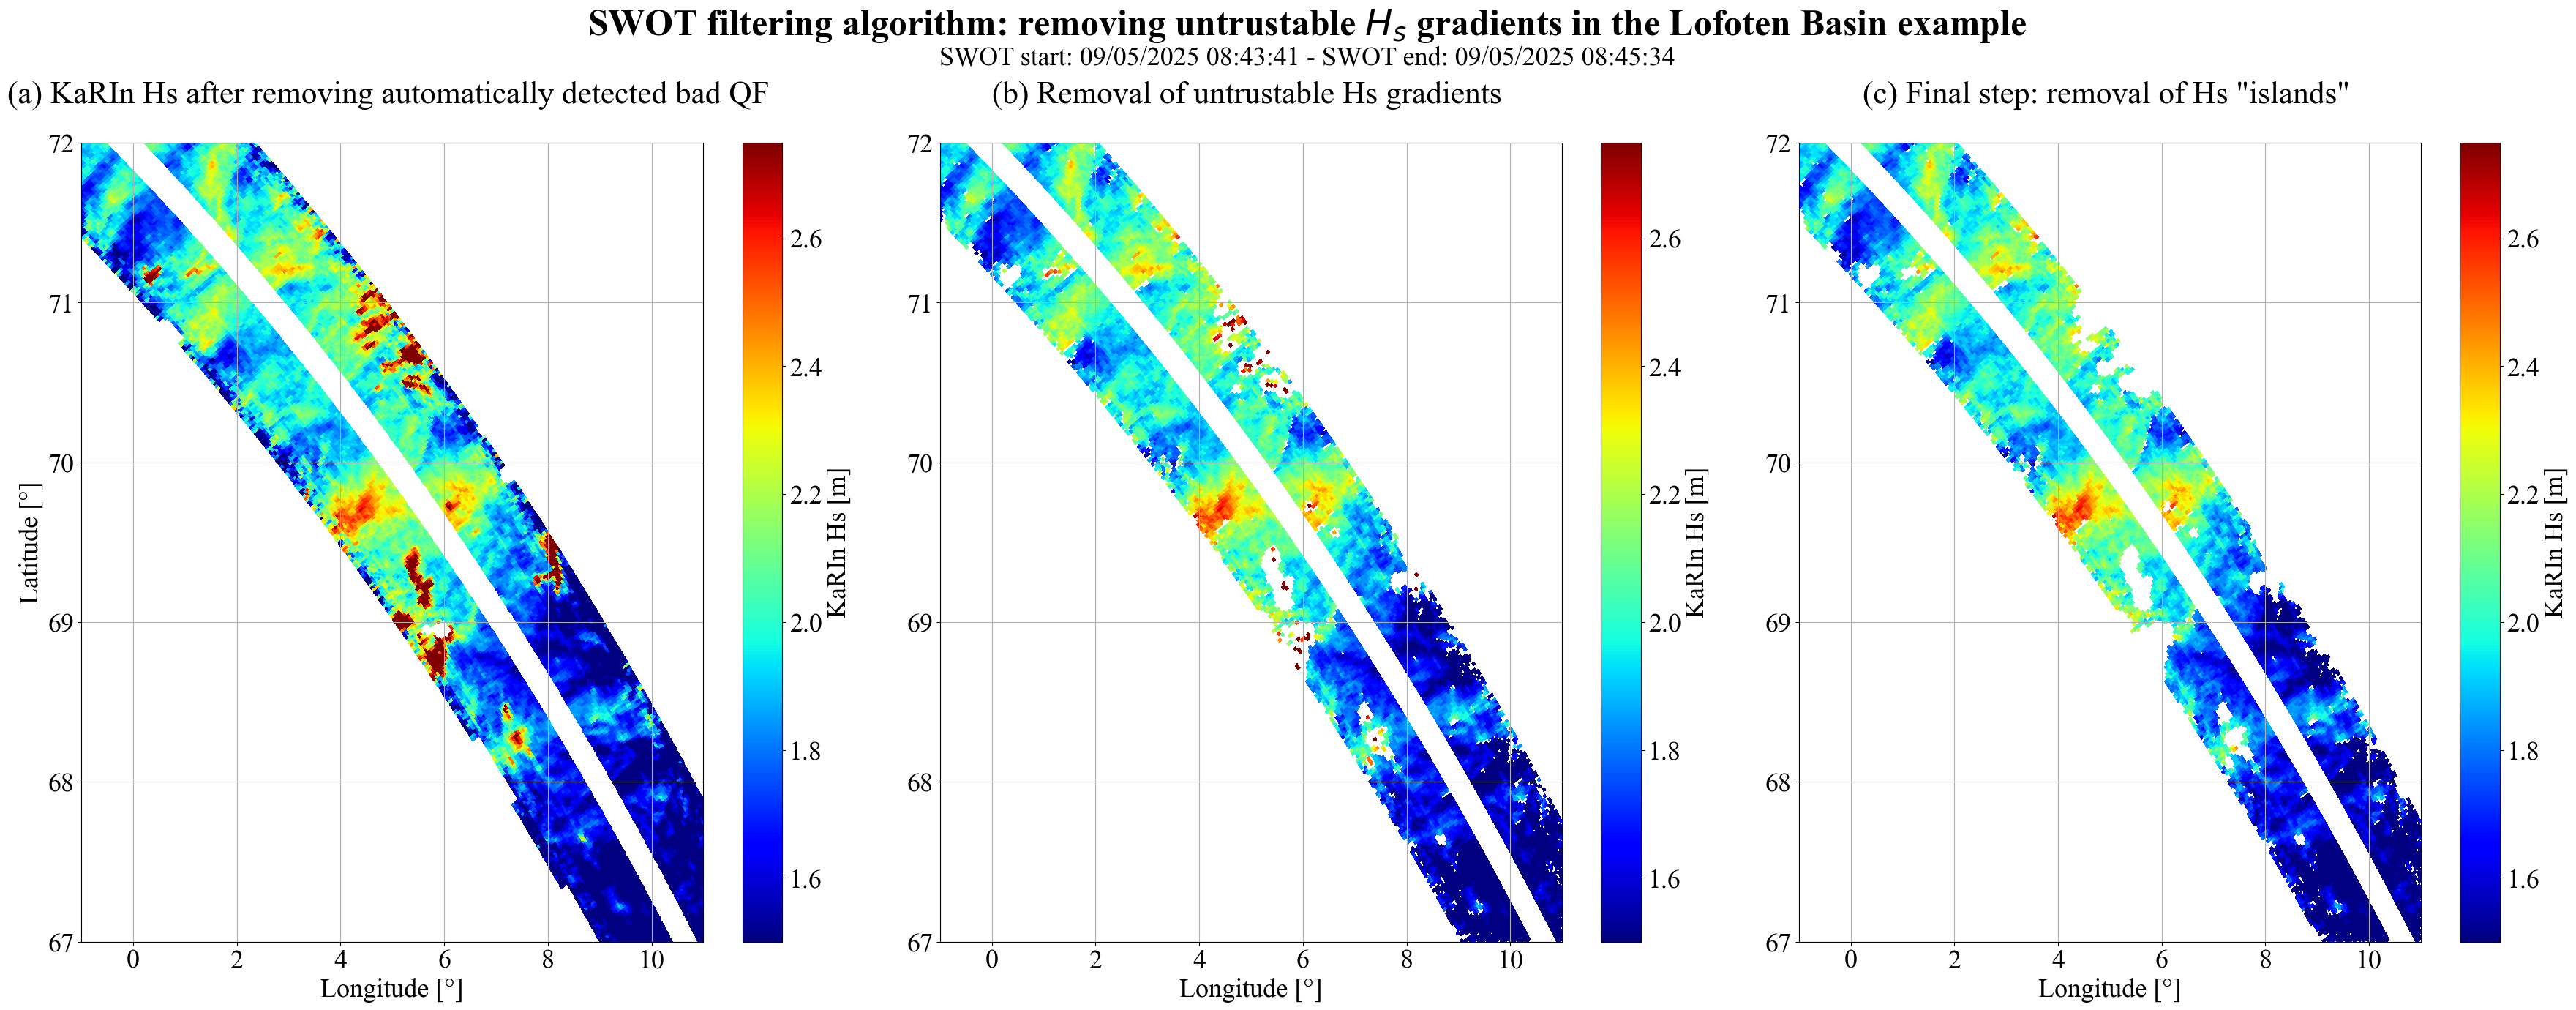

In [10]:
Lx, Ly = st.geoscale_fig(lon_map_min, lon_map_max, lat_map_min, lat_map_max, Lx=4)
show_swot=True
plt.rcParams.update({'font.size': 26})  
lon_swot, lat_swot = ds_swot.longitude, ds_swot.latitude
if show_swot:
    n_p = 3
    fig, ax = plt.subplots(1, n_p, figsize=(n_p*Lx, Ly))

    ds_swot_morning = ds_swot_morning.where(ds_swot_morning.rain_flag == 0)
    im0 = ds_swot_morning.swh_karin.plot(x="longitude",y="latitude", cmap="jet", ax=ax[0], add_colorbar=False, vmin=1.5, vmax=2.75)
    ax[0].set_title("(a) KaRIn Hs after removing automatically detected bad QF \n")
    plt.colorbar(im0, label="KaRIn Hs [m]")

    """
    im1 = ax[1].pcolor(lon_swot, lat_swot, ds_swot.dHsdx, cmap="seismic", vmin=-1/4, vmax =1/4)
    ax[1].set_title(r"(b) Hs gradient across track: $\dfrac{\partial H_s}{\partial x}$" + "\n")
    plt.colorbar(im1, label=r"$\dfrac{\partial H_s}{\partial x}$ [m/km]")
    
    im2 = ax[2].pcolor(lon_swot, lat_swot, ds_swot.dHsdy, cmap="seismic", vmin=-1/4, vmax =1/4)
    ax[2].set_title(r"(c) Hs gradient along track: $\dfrac{\partial H_s}{\partial y}$"+ "\n")
    plt.colorbar(im2, label=r"$\dfrac{\partial H_s}{\partial y}$ [m/km]")
    """

    ds_swot= ds_swot.where(ds_swot.rain_flag == 0)

    im1 = ax[1].pcolor(lon_swot, lat_swot, ds_swot.swh_karin_clean_step_1, cmap="jet", vmin=1.5, vmax =2.75)
    ax[1].set_title("(b) Removal of untrustable Hs gradients \n")
    plt.colorbar(im1, label="KaRIn Hs [m]")

    im2 = ax[2].pcolor(lon_swot, lat_swot, ds_swot.swh_karin_fully_cleaned, cmap="jet", vmin=1.5, vmax =2.75)
    ax[2].set_title('(c) Final step: removal of Hs "islands" \n')
    plt.colorbar(im2, label="KaRIn Hs [m]")
    
    """
    im5 = ax[5].pcolor(lon_swot, lat_swot, swh_karin_clean_sig0, cmap="jet", vmin=1.5, vmax =2.75)
    plt.colorbar(im5, label="Clean Hs [m]")
    ax[5].set_title("Cleaned Hs sig0")

    im6 = ax[6].pcolor(lon_swot, lat_swot, swh_karin_clean_encore_plus_sig0, cmap="jet", vmin=1.5, vmax =2.75)
    plt.colorbar(im6, label="Super clean Hs [m]")
    ax[6].set_title("Super cleaned Hs")
    """
    #ds_swot.swh_karin.plot(x="longitude",y="latitude", cmap="jet", ax=ax[5],vmin=1, vmax=3)
    plt.rcParams.update({'font.size': 36})  
    ax[0].set_ylabel("Latitude [°]")

    for i in range(n_p):
        ax[i].grid()
        ax[i].set_xlim(lon_map_min, lon_map_max)
        ax[i].set_ylim(lat_map_min, lat_map_max)
    
        ax[i].set_xlabel("Longitude [°]")
        
    
    fig.suptitle(r"SWOT filtering algorithm: removing untrustable $H_s$ gradients in the Lofoten Basin example", fontproperties=font_bold, fontsize=36)
    plt.rcParams.update({'font.size': 26})  
    fig.text(x=0.5,y=0.925,s=f"SWOT start: {t_ini_swot_formatted} - SWOT end: {t_end_swot_formatted}", ha="center")
    plt.tight_layout()
    plt.savefig("output_images/LF/SWOT_filtering_rmv_grad.png")
    plt.show()
    
        


In [11]:
for i, v in ds_swot.variables.items():
    try:
        print(f"- \033[1m{i}\033[0m : {v.attrs['long_name']}")
    except KeyError:
        print(f"- \033[1m{i}\033[0m : {v.attrs}")

- time : time in UTC
- time_tai : time in TAI
- polarization_karin : polarization for each side of the KaRIn swath
- swh_karin : {}
- swh_karin_qual : quality flag for significant wave height from KaRIn.
- swh_karin_uncert : 1-sigma uncertainty on significant wave height from KaRIn
- sig0_karin : normalized radar cross section (sigma0) from KaRIn
- sig0_karin_qual : quality flag for sigma0 from KaRIn.
- sig0_karin_uncert : 1-sigma uncertainty on sigma0 from KaRIn
- sig0_karin_2 : normalized radar cross section (sigma0) from KaRIn
- sig0_karin_2_qual : quality flag for sigma0 from KaRIn.
- wind_speed_karin : wind speed from KaRIn
- wind_speed_karin_qual : quality flag for wind speed from KaRIn.
- wind_speed_karin_2 : wind speed from KaRIn
- wind_speed_karin_2_qual : quality flag for wind speed from KaRIn.
- num_pt_avg : number of samples averaged
- swh_wind_speed_karin_source : source flag for significant wave height information used to compute wind speed from KaRIn
- swh_wind_speed_kar

In [12]:
### Chargement du vent issu du modèle que propose la donnée SWOT 
u_wind_mod_night = ds_swot_night.wind_speed_model_u.values
v_wind_mod_night = ds_swot_night.wind_speed_model_v.values

u_wind_mod_morning = ds_swot_morning.wind_speed_model_u.values
v_wind_mod_morning = ds_swot_morning.wind_speed_model_v.values

In [13]:
### Chargement des courants ww3 / vardyn

# WW3 - Globcurrent-30M
ds_ww3 = xr.open_dataset(r"data/ww3/ww3_LE_20250509.nc")
ds_09 = ds_ww3.isel(time=[13])
ds_09 = ds_09.where((ds_09.longitude >= lon_map_min) & (ds_09.longitude <= lon_map_max) & (ds_09.latitude >= lat_map_min) & (ds_09.latitude <= lat_map_max), drop=True)
ds_09 = ds_09.squeeze()

show_globcurrent = False

X = ds_09.longitude.values # (13,)
Y = ds_09.latitude.values # (9,)
ucur_09 = ds_09.ucur.values #
ucur_09 = ucur_09.reshape(len(Y),len(X)) # (n_lat, n_lon, 1) ==> (n_lat, n_lon) i.e. (9, 13)
vcur_09 = ds_09.vcur.values
vcur_09 = vcur_09.reshape(len(Y),len(X)) # (n_lat, n_lon, 1) ==> (n_lat, n_lon) i.e. (9, 13)

X_grid, Y_grid = np.meshgrid(X, Y)

# WW3 - Direction
"""
ds_ww3 = xr.open_mfdataset("/home/datawork-WW3/PROJECT/SWOT/HR-WW3/TEST_DIA_202505_CUR/*.nc", engine="netcdf4")
ds_ww3 = ds_ww3.sel(longitude=slice(-30,10), latitude=slice(50, 80))
ds_09 = ds_ww3.isel(time=201)
ds_09 = ds_09.where((ds_09.longitude >= lon_map_min) & (ds_09.longitude <= lon_map_max) & (ds_09.latitude >= lat_map_min) & (ds_09.latitude <= lat_map_max), drop=True)
"""
hs, hs_ww, hs_1st = ds_09.hs.values, ds_09.phs0.values, ds_09.phs1.values
max_mag = np.max([np.nanmax(ds_09.hs.values), np.nanmax(ds_09.phs0.values), np.nanmax(ds_09.phs1.values)])
arrow_length = 0.07
scale_ww3 = max_mag / arrow_length


wave_dir = ds_09.dir.values
u_wave_dir = hs*np.sin(np.pi*(wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_wave_dir = hs*np.cos(np.pi*(wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180


first_wave_dir = ds_09.pdir1.values
u_1st_wave_dir = hs_1st*np.sin(np.pi*(first_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_1st_wave_dir = hs_1st*np.cos(np.pi*(first_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

windwave_dir = ds_09.pdir0.values
u_windwave_dir = hs_ww*np.sin(np.pi*(windwave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_windwave_dir = hs_ww*np.cos(np.pi*(windwave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180




# Vardyn
new_file = True

if new_file:
    ds_vardyn = xr.open_dataset(r"data/vardyn/2025/129/VarDyn_Lofoten_SWOT_allNadirs.nc")
    ds_vardyn = ds_vardyn.isel(time=153)
    ds_vardyn = ds_vardyn.where((ds_vardyn.lon >= lon_map_min) & (ds_vardyn.lon <= lon_map_max) & (ds_vardyn.lat>= lat_map_min) & (ds_vardyn.lat <= lat_map_max), drop=True)
    X_vd_grid = ds_vardyn.lon.values # shape (113, 175)
    Y_vd_grid = ds_vardyn.lat.values # shape (113, 175)
    u_vd = ds_vardyn.u
    v_vd = ds_vardyn.v
    norm_U_vd = 100*np.sqrt(u_vd**2 + v_vd**2) 

    max_mag_vd = np.nanmax(norm_U_vd)
    arrow_length = 1.5*3.62
    scale_vd = max_mag_vd / arrow_length


else:
    ds_vardyn = xr.open_dataset(r"/home1/datawork/msimonne/LE_20250509/vardyn/vardyn_otc2025_20250509000000_L4_v1.0_fv1.0/vardyn_otc2025_20250509000000_L4_v1.0_fv1.0_idf_00.nc")
    ds_vardyn = ds_vardyn.sel(lon_gcp=slice(lon_map_min,lon_map_max), lat_gcp = slice(lat_map_min,lat_map_max))
    
    idx_lon_min, idx_lon_max = np.min(ds_vardyn.index_lon_gcp), np.max(ds_vardyn.index_lon_gcp)
    idx_lat_min, idx_lat_max = np.min(ds_vardyn.index_lat_gcp), np.max(ds_vardyn.index_lat_gcp)
    ds_vardyn = ds_vardyn.isel(lon=slice(int(idx_lon_min),int(idx_lon_max)+1), lat = slice(int(idx_lat_min),int(idx_lat_max)+1))
    
    X_vd = np.array([round(round(float(ds_vardyn.lon_gcp.values[0]),2) + 0.1*k,2) for k in range(len(ds_vardyn.lon))])
    Y_vd = np.array([round(round(float(ds_vardyn.lat_gcp.values[0]),2) + 0.1*k,2) for k in range(len(ds_vardyn.lat))])
    X_vd_grid, Y_vd_grid = np.meshgrid(X_vd, Y_vd)

    u_vd = ds_vardyn.u.isel(time=0) # Sinon on a 5 dimensions
    v_vd = ds_vardyn.v.isel(time=0) # Sinon on a 5 dimensions
    norm_U_vd = 100*np.sqrt(u_vd**2 + v_vd**2) 

In [14]:
### Chargement de MFWAM
time_mfwam_idx = 1 # 06:00:00
ds_mfwam = xr.open_dataset(r"data/mfwam/mfwamglocep_2025050900_R20250510_00H.nc")
ds_mfwam = ds_mfwam.where((ds_mfwam.longitude >= lon_map_min) & (ds_mfwam.longitude <= lon_map_max) & (ds_mfwam.latitude >= lat_map_min) & (ds_mfwam.latitude <= lat_map_max), drop=True)

X_mfwam, Y_mfwam = ds_mfwam.longitude.values, ds_mfwam.latitude.values
X_mfwam_grid, Y_mfwam_grid = np.meshgrid(X_mfwam, Y_mfwam)

mean_wave_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR.values
hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0.values
u_mean_wave_dir = hs*np.sin(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_mean_wave_dir = hs*np.cos(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw1_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW1.values
sw1_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW1.values
u_sw1_dir = sw1_hs*np.sin(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw1_dir = sw1_hs*np.cos(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw2_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW2.values
sw2_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW2.values
u_sw2_dir = sw2_hs*np.sin(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw2_dir = sw2_hs*np.cos(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

ww_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_WW.values
ww_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_WW.values
u_ww_dir = ww_hs*np.sin(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_ww_dir = ww_hs*np.cos(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

max_mag = np.max([np.nanmax(sw1_hs), np.nanmax(ww_hs)])
arrow_length = 0.07
scale = max_mag / arrow_length


In [15]:
### Formatting times for plots


## SWOT
t_ini_swot = np.nanmin(ds_swot.time.values)
# Convert np.datetime64 to Python datetime
t_ini_swot = t_ini_swot.astype('datetime64[s]').tolist()
# Format the datetime object to desired string format
#t_ini_swot_formatted = t_ini_swot.strftime("%d/%m/%Y %H:%M:%S")
t_ini_swot_formatted = t_ini_swot.strftime("%H:%M:%S")

t_end_swot = np.nanmax(ds_swot.time.values)
# Convert np.datetime64 to Python datetime
t_end_swot = t_end_swot.astype('datetime64[s]').tolist()
# Format the datetime object to desired string format
#t_end_swot_formatted = t_end_swot.strftime("%d/%m/%Y %H:%M:%S")
t_end_swot_formatted = t_end_swot.strftime("%H:%M:%S")

## MFWAM
t_mfwam = ds_mfwam.isel(time=time_mfwam_idx).time.values
# Convert np.datetime64 to Python datetime
t_mfwam = t_mfwam.astype('datetime64[s]').tolist()
# Format the datetime object to desired string format
#t_mfwam_formatted = t_mfwam.strftime("%d/%m/%Y %H:%M:%S")
t_mfwam_formatted = t_mfwam.strftime("%H:%M:%S")


## VarDyn
#t_vardyn = ds_vardyn.isel(time=0).time.values
t_vardyn = ds_vardyn.time.values
# Convert np.datetime64 to Python datetime
t_vardyn = t_vardyn.astype('datetime64[s]').tolist()
# Format the datetime object to desired string format
#t_vardyn_formatted = t_vardyn.strftime("%d/%m/%Y %H:%M:%S")
t_vardyn_formatted = t_vardyn.strftime("%H:%M:%S")


In [16]:
def plot_ombs(buoys_area=["14","15","19","20"], t_ini ='2025-05-09T00:00:00', t_end='2025-05-10T00:00:00', hs_min=1.5, hs_max=2.75):
    ds_ombs = xr.open_dataset(r"data/omb/2025-otc-omb.nc")
    #buoys_lofoten = ["14","15","19","20"]
    #buoys_area = buoys_lofoten
    buoy_labels = ["OMB-2024-" + number for number in buoys_area]
    
    for buoy_name in buoy_labels:#ds_ombs.trajectory:
        ds = ds_ombs.sel(trajectory=buoy_name)
        ds = ds.where(ds.time > np.datetime64(t_ini + '.000000000'), drop=True)
        ds = ds.where(ds.time < np.datetime64(t_end + '.000000000'), drop=True)
        ds = ds.where(ds.time_waves_imu > np.datetime64(t_ini + '.000000000'), drop=True)
        ds = ds.where(ds.time_waves_imu < np.datetime64(t_end + '.000000000'), drop=True)
        time_all = ds.time.values[:,0]
        time_waves_imu_with_nat = ds.time_waves_imu.values[:,0]
        time_waves_imu = time_waves_imu_with_nat[~np.isnat(time_waves_imu_with_nat)] # on vire les nat 
    
        lon = ds.lon.values
        lon = lon[np.isfinite(lon)]
        lat = ds.lat.values
        lat = lat[np.isfinite(lat)]
        Hs0 = ds.Hs0.values[:,0]
        pHs0 = ds.pHs0.values[:,0]
        
    
        
    
        # Get indices in time_all where each time_waves_imu would be inserted
        indices = np.searchsorted(time_all, time_waves_imu, side='right') - 1
    
        # Handle case where the wave time is earlier than all in time_all
        indices[indices < 0] = -1  # or np.nan if preferred
    
        indices_p_1 = [idx + 1 for idx in indices]
        try:
            dt_time_all = (time_all[indices_p_1] - time_all[indices] ) / np.timedelta64(1,'h')
        except IndexError:
            dt_time_all = np.ones(indices.shape)
            dt_time_all[:-1] = (time_all[indices_p_1[:-1]] - time_all[indices[:-1]] ) / np.timedelta64(1,'h')
            dt_time_all[-1] = dt_time_all[-2]
            
        delta_t = (time_waves_imu - time_all[indices]) / np.timedelta64(1, 'h')
    
        Weights = delta_t / dt_time_all
        try:
            lon_waves_imu = Weights*lon[indices_p_1] + (1-Weights)*lon[indices]
            lat_waves_imu = Weights*lat[indices_p_1] + (1-Weights)*lat[indices]
        except IndexError:
            lon_waves_imu, lat_waves_imu = np.ones(Weights.shape), np.ones(Weights.shape)
            lon_waves_imu[:-1] = Weights[:-1]*lon[indices_p_1[:-1]] + (1-Weights[:-1])*lon[indices[:-1]]
            lat_waves_imu[:-1] = Weights[:-1]*lat[indices_p_1[:-1]] + (1-Weights[:-1])*lat[indices[:-1]]
            lon_waves_imu[-1] = lon_waves_imu[-2]
            lat_waves_imu[-1] = lat_waves_imu[-2]
    
            
    
        
        
        eps = 0.01
        if buoy_name[-2:] != "20":
            plt.scatter(lon_waves_imu, lat_waves_imu, c=Hs0[~np.isnat(time_waves_imu_with_nat)], cmap="jet",vmin = hs_min, vmax = hs_max, s=100, edgecolors='black', marker="s", linewidth=0.8)
            plt.text(lon_waves_imu[len(lon_waves_imu)//2] + 12*eps, lat_waves_imu[len(lat_waves_imu)//2] + eps, buoy_name, fontweight='bold', color="white", fontsize = 13)
        else:
            plt.scatter(lon_waves_imu, lat_waves_imu -eps, c=Hs0[~np.isnat(time_waves_imu_with_nat)], cmap="jet",vmin = hs_min, vmax = hs_max, s=100, edgecolors='black',linewidth=0.8, marker = "s", label="OMB")
            plt.text(lon_waves_imu[len(lon_waves_imu)//2] + 12*eps, lat_waves_imu[len(lat_waves_imu)//2] - 8*eps, buoy_name, fontweight='bold', color="white", fontsize = 13) # was - 3 eps, not -5
        #plt.scatter(lon_waves_imu,lat_waves_imu,label=str(buoy_name)[-2:])
    
    #plt.colorbar(label="Hs [m]")
    #plt.xlim(0,10)
    #plt.ylim(67.5, 71.5)
    #plt.grid()
    #plt.xlabel("Longitude [°]")
    #plt.ylabel("Latitude [°]")
    #plt.show()


dx (km): 233.34, dy (km): 195.48, scale: 0.84


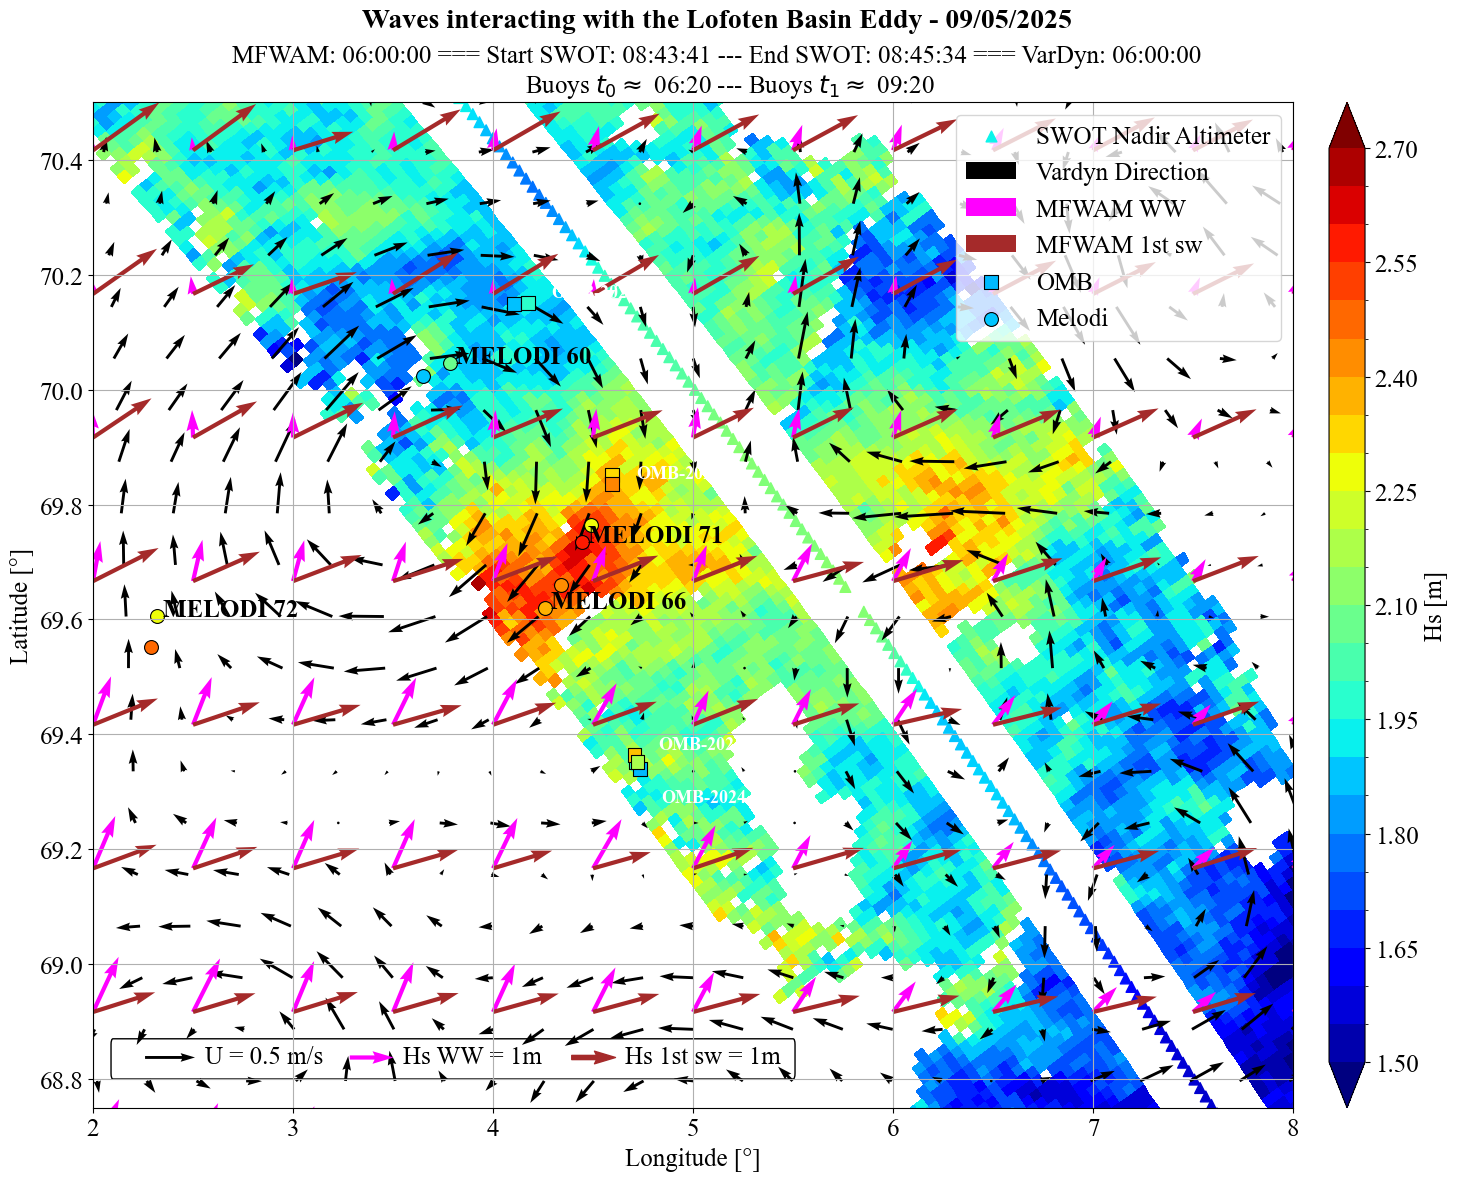

In [19]:
#%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata

# Geographic bounds
#lon_map_min, lon_map_max = 2, 8
#lat_map_min, lat_map_max = 68.75, 70.5
lon_map_min, lon_map_max, lat_map_min, lat_map_max = 2, 8, 68.75, 70.5
Lofoten_area = [lon_map_min, lon_map_max, lat_map_min, lat_map_max]

# Colormap bounds
hs_min, hs_max = 1.5, 2.75
cmap_lofoten_levels = np.arange(hs_min,hs_max,0.05)
cmap_levels = cmap_lofoten_levels
cmap = 'jet'

# Geographic scaling
Rt = 6400  # km
mean_lat_rad = np.radians((lat_map_min + lat_map_max)/2)
dx = Rt * np.cos(mean_lat_rad) * np.radians(lon_map_max - lon_map_min)
dy = Rt * np.radians(lat_map_max - lat_map_min)
scale_fact = dy / dx

print(f"dx (km): {dx:.2f}, dy (km): {dy:.2f}, scale: {scale_fact:.2f}")

# Full figure size
Lx = 12  # inches
Ly = Lx * scale_fact

plt.rcParams.update({'font.size': 18})  
fig = plt.figure(figsize=(Lx, Ly))

# Axes occupy full figure area
scale_ax = 1
ax = fig.add_axes([0, 0, scale_ax, scale_ax])  # left, bottom, width, height (relative 0–1)


# Set axis limits
ax.set_xlim(lon_map_min, lon_map_max)
ax.set_ylim(lat_map_min, lat_map_max)



# Add suptitle manually, outside of axis (won't affect aspect ratio)
#fig.text(0.5, 1.02, "Waves interacting with the Lofoten Eddy - 09/05/2025\n  MFWAM: {} === Start SWOT: {} --- End SWOT: {} === VarDyn: {} \n    Start OMB: 06:21:59 --- End OMB: 09:21:39".format(t_mfwam_formatted, t_ini_swot_formatted, t_end_swot_formatted, t_vardyn_formatted), ha='center', fontproperties=font_bold)
fig.text(0.52, 1.075, "Waves interacting with the Lofoten Basin Eddy - 09/05/2025", ha='center', fontproperties=font_bold, fontsize=20)
fig.text(0.52, 1.01, "MFWAM: {} === Start SWOT: {} --- End SWOT: {} === VarDyn: {}\n{}".format(t_mfwam_formatted, t_ini_swot_formatted, t_end_swot_formatted, t_vardyn_formatted,r"    Buoys $t_0 \approx$ 06:20 --- Buoys $t_1 \approx$ 09:20"), ha='center')


#plt.suptitle("SWH and T0m1 inferred from Sentinel-1 SAR IW\n Start IW: {} --- End IW: {} \n Start SWOT: {} --- End SWOT: {}".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted))


# === Plot content ===
# IW part
show_IW = False
if show_IW:
    # Create grid --> à revoir pour faire un truc à 5km de résolution
    xi = np.linspace(lon_map_min, lon_map_max, int(dx/5)) # int(dx/5) car dx est en km et SARWAVE à 5km de résolution 
    yi = np.linspace(lat_map_min, lat_map_max, int(dy/5))
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate data onto grid
    zi = griddata((lon_hsml_gro_array, lat_hsml_gro_array), HSML_gro_array, (xi, yi), method='linear')
    
    # Plot
    ax.pcolormesh(xi, yi, zi, cmap='jet', vmin=hs_min, vmax=hs_max)
    #ax.scatter(lon_hsml_gro_array, lat_hsml_gro_array, c=HSML_gro_array, vmin=hs_min, vmax=hs_max,cmap="jet", s=100)

# KaRIn PART
show_hs_swot = True
if show_hs_swot:
    im = ds_swot.swh_karin.plot.pcolormesh(
        x='longitude', y='latitude', ax=ax, levels=cmap_lofoten_levels,
        cmap=cmap, add_colorbar=False, extend='both'
    )
    lat_nadir = ds_swot.latitude.isel(num_pixels=33).values
    lon_nadir = ds_swot.longitude.isel(num_pixels=33).values
    ax.scatter(lon_nadir, lat_nadir, c=ds_swot.swh_nadir_altimeter.values[:,27], vmin=hs_min, vmax=hs_max, cmap='jet', marker="^", s=60)
    ax.scatter(lon_nadir[12], lat_nadir[12], c=ds_swot.swh_nadir_altimeter.values[47,27], vmin=hs_min, vmax=hs_max,  cmap='jet', marker="^", s=60, label="SWOT Nadir Altimeter") # for nadir

# Quivers, buoys, etc. remain unchanged (as you're already plotting directly into ax)
ax.grid()
# Add fixed size white rectangle
rect = patches.FancyBboxPatch(
    (2.1, 68.81),  # bottom left corner in data coords
    width=3.4, height=0.05, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
ax.add_patch(rect)

# IW part
show_IW = False
if show_IW:
    # Create grid --> à revoir pour faire un truc à 5km de résolution
    xi = np.linspace(lon_map_min, lon_map_max, int(dx/5)) # int(dx/5) car dx est en km et SARWAVE à 5km de résolution 
    yi = np.linspace(lat_map_min, lat_map_max, int(dy/5))
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate data onto grid
    zi = griddata((lon_hsml_gro_array, lat_hsml_gro_array), HSML_gro_array, (xi, yi), method='linear')
    
    # Plot
    ax.pcolormesh(xi, yi, zi, cmap='jet', vmin=hs_min, vmax=hs_max)
    #ax.scatter(lon_hsml_gro_array, lat_hsml_gro_array, c=HSML_gro_array, vmin=hs_min, vmax=hs_max,cmap="jet", s=100)

# QUIVER PART
show_vardyn = True
if show_vardyn:
    step_vd = 2
    q = ax.quiver(X_vd_grid[2*step_vd::step_vd,::step_vd], Y_vd_grid[2*step_vd::step_vd,::step_vd], u_vd[2*step_vd::step_vd,::step_vd], v_vd[2*step_vd::step_vd,::step_vd], color="black", label="Vardyn Direction", scale=scale_vd)
    # Add a quiver key to indicate vector scale
    ax.quiverkey(q, X=0.085, Y=0.05, U=0.5,label='U = 0.5 m/s ', labelpos='E')
    

show_glocurrent=False
if show_globcurrent:
    plt.quiver(X_grid, Y_grid ,ucur_09, vcur_09)
    
show_ww3_mean_wave_dir = False
if show_ww3_mean_wave_dir:
    plt.quiver(X_grid, Y_grid, u_1st_wave_dir, v_1st_wave_dir, label="WW3 1st swell dir", color="blue", alpha=0.9, scale = scale_ww3)
    plt.quiver(X_grid, Y_grid, u_wave_dir, v_wave_dir, label="WW3 wave mean direction", color="black", alpha=0.9, scale = scale_ww3)
    plt.quiver(X_grid, Y_grid, u_windwave_dir, v_windwave_dir, label="WW3 Windwave dir", color="purple", alpha=0.9, scale = scale_ww3)


    

show_mfwam_dir = True
if show_mfwam_dir:
    step_mfwam = 3
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::step_mfwam] ,u_mean_wave_dir[::step_mfwam,::step_mfwam], v_mean_wave_dir[::step_mfwam,::step_mfwam], color = "blue", label="MFWAM mean dir", linewidth = 1)
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::steµp_mfwam] ,u_sw2_dir[::step_mfwam,::step_mfwam], v_sw2_dir[::step_mfwam,::step_mfwam], color = "purple", alpha = 0.5, label="MFWAM 2nd sw", linewidth = 1)
    q = ax.quiver(X_mfwam_grid[2::step_mfwam,::2*step_mfwam], Y_mfwam_grid[2::step_mfwam,::2*step_mfwam] ,u_ww_dir[2::step_mfwam,::2*step_mfwam], v_ww_dir[2::step_mfwam,::2*step_mfwam], color="magenta", label="MFWAM WW", scale=scale, width = 0.0035)#, scale_units='xy')
    ax.quiverkey(q, X=0.25, Y=0.05, U=1,label='Hs WW = 1m ',color = "magenta", labelpos='E')
    q = plt.quiver(X_mfwam_grid[2::step_mfwam,::2*step_mfwam], Y_mfwam_grid[2::step_mfwam,::2*step_mfwam] ,u_sw1_dir[2::step_mfwam,::2*step_mfwam], v_sw1_dir[2::step_mfwam,::2*step_mfwam], color = "brown", label="MFWAM 1st sw", scale=scale, lw=1, width=0.0035)
    ax.quiverkey(q, X=0.435, Y=0.05, U=1,label='Hs 1st sw = 1m ',color = "brown", labelpos='E')

show_swot_wind_model = False
if show_swot_wind_model:
    step = 6
    plt.quiver(ds_swot_morning.longitude.values[::step,::step], ds_swot_morning.latitude.values[::step,::step], u_wind_mod_morning[::step,::step], v_wind_mod_morning[::step,::step], label="SWOT model Wind")
    plt.quiver(ds_swot_night.longitude.values[::step,::step], ds_swot_night.latitude.values[::step,::step], u_wind_mod_night[::step,::step], v_wind_mod_night[::step,::step])


# Coastlines (assuming show_shp works)
# st.show_shp(ax, sf_world, zorder=0, color='lightgrey')
# st.show_shp(ax, sf_antarctique, zorder=0, color='lightgrey')


# Buoy overlay and other plotting code go here...
plot_ombs(buoys_area=["14","15","19","20"], t_ini ='2025-05-09T06:00:00', t_end='2025-05-09T12:00:00', hs_min=hs_min, hs_max=hs_max)

df_Melodi_filtered = pd.read_csv("B_df/df_melodi_buoy_LBE_0905.csv", index_col=0)
#df_Melodi_filtered = pd.read_csv("B_df/df_ww3_on_lofoten_buoys.csv", index_col=0)

Lab = [60, 66, 71, 72, 60, 66, 71, 72]
Idx = [1609, 4834, 8112, 11315,1633, 4859, 8136, 11339]
eps = 0.01

for i, b_lab in enumerate(Lab): 
    idx = Idx[i]
    df_i = df_Melodi_filtered.loc[idx]
    lon_b, lat_b, hs_b = df_i["lon_b"], df_i["lat_b"], df_i["Hs_b_filt_new"]
    if i == 0:
        plt.scatter(lon_b, lat_b, c=hs_b, cmap="jet",vmin = hs_min, vmax = hs_max, s=100, edgecolors='black',linewidth=0.8, label="Melodi")
    else:
        plt.scatter(lon_b, lat_b, c=hs_b, cmap="jet",vmin = hs_min, vmax = hs_max, s=100, edgecolors='black',linewidth=0.8)

    if i >= 4:
        plt.text(lon_b + 3*eps, lat_b, f"MELODI {b_lab}", fontweight='bold', color="black")

        
# Add inset colorbar that won't affect layout
cax = inset_axes(ax, width="3%", height="100%", loc='lower left',
                 bbox_to_anchor=(1.03, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(im, cax=cax, orientation='vertical', label="Hs [m]")

# Labels and legend
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
ax.legend()

plt.savefig(fname="output_images/LF/LF_synergy.png", bbox_inches='tight')
plt.show()


In [20]:
df_Melodi_filtered = pd.read_csv("B_df/df_melodi_buoy_LBE_0905.csv")
df_Melodi_filtered

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0     lon_b      lat_b  WW3_Hs_on_b  \
0            1575          1575         0.0  3.480470  69.998220     2.232236   
1            1576          1576         0.0  3.488840  69.999550     2.235016   
2            1577          1577         0.0  3.488840  69.999550     2.235731   
3            1578          1578         0.0  3.497150  70.000940     2.238167   
4            1579          1579         0.0  3.505220  70.002380     2.237939   
..            ...           ...         ...       ...        ...          ...   
346         13169             0         NaN  2.703444  69.314264     2.352050   
347         13287             0         NaN  2.717347  69.316008     2.290461   
348         13288             0         NaN  2.717347  69.316008     2.330694   
349         13289             0         NaN  2.717347  69.316008     2.418271   
350         13290             0         NaN  2.717347  69.316008     2.353239   

         Hs_b Hs_b_filt b_type             datetime  idx_no_nan        b_lab  \
0    1.150000      [0.]      m  2025-05-09 02:34:00      8619.0         60.0   
1    1.150000      [0.]      m  2025-05-09 02:44:00      8626.0         60.0   
2    1.150000      [0.]      m  2025-05-09 02:46:00      8627.0         60.0   
3    1.150000      [0.]      m  2025-05-09 02:55:00      8634.0         60.0   
4    1.150000      [0.]      m  2025-05-09 03:05:00      8641.0         60.0   
..        ...       ...    ...                  ...         ...          ...   
346  2.374731      [0.]    omb  2025-05-09 12:22:53        68.0  OMB-2024-19   
347  1.824714      [0.]    omb  2025-05-09 03:21:38        65.0  OMB-2024-20   
348  1.881886      [0.]    omb  2025-05-09 06:21:59        66.0  OMB-2024-20   
349  2.196737      [0.]    omb  2025-05-09 09:21:39        67.0  OMB-2024-20   
350  2.362971      [0.]    omb  2025-05-09 12:21:38        68.0  OMB-2024-20   

     Hs_b_filt_new  
0             1.80  
1             1.80  
2             1.80  
3             1.80  
4             1.80  
..             ...  
346           0.65  
347           0.65  
348           0.65  
349           0.65  
350           0.65  

[351 rows x 13 columns]

dx (km): 469.42, dy (km): 558.51, scale: 1.19


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


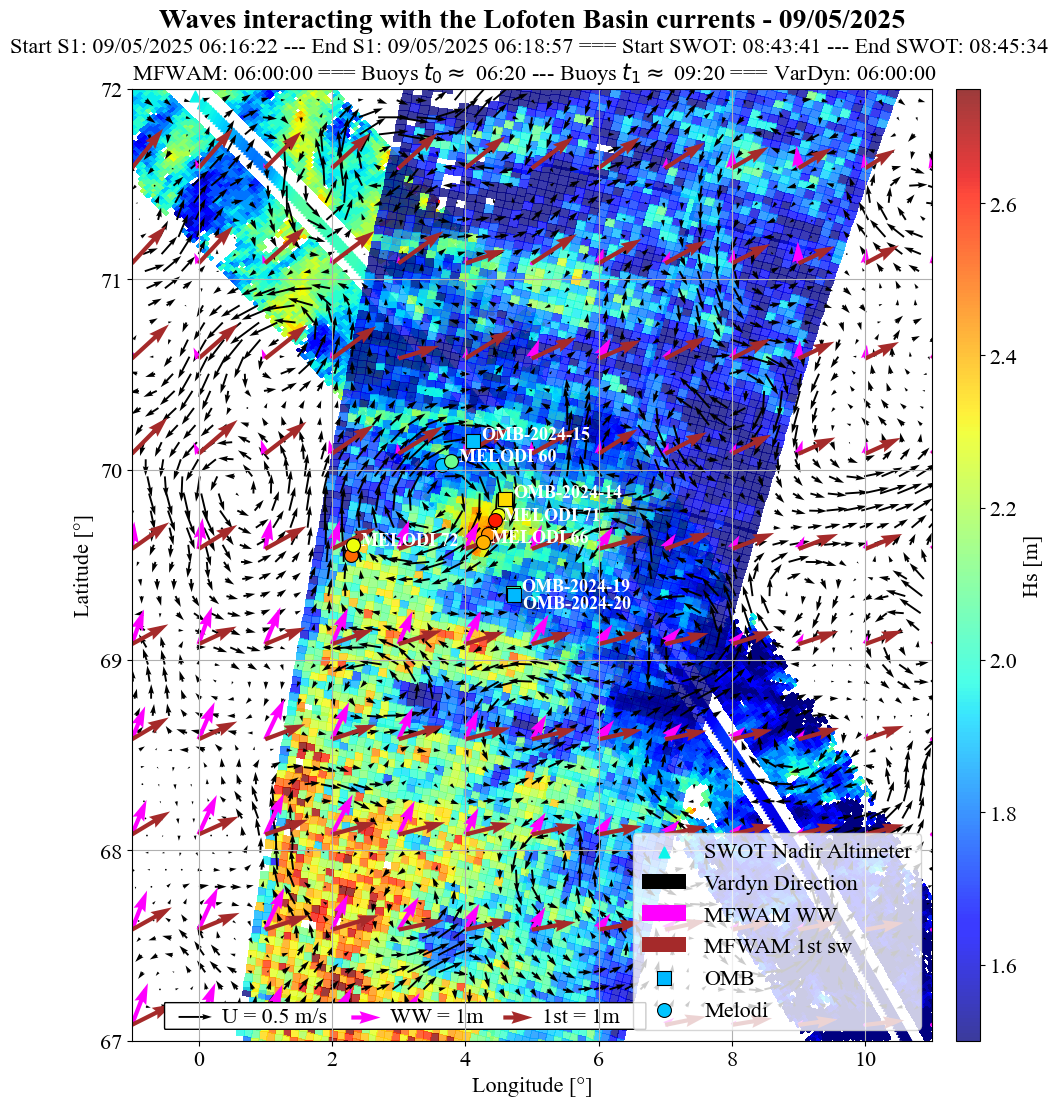

In [21]:
#%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata

# Geographic bounds
lon_map_min, lon_map_max, lat_map_min, lat_map_max = -1, 11, 67, 72
Lofoten_area = [lon_map_min, lon_map_max, lat_map_min, lat_map_max]
conf_rate_min = -0.5

# Colormap bounds
hs_min, hs_max = 1.5, 2.75
#hs_min, hs_max = 1.2, 2.4
#hs_min, hs_max = 1.4, 2.6
cmap_lofoten_levels = np.arange(hs_min,hs_max,0.05)
cmap_levels = cmap_lofoten_levels
cmap = 'jet'

# Geographic scaling
Rt = 6400  # km
mean_lat_rad = np.radians((lat_map_min + lat_map_max)/2)
dx = Rt * np.cos(mean_lat_rad) * np.radians(lon_map_max - lon_map_min)
dy = Rt * np.radians(lat_map_max - lat_map_min)
scale_fact = dy / dx

print(f"dx (km): {dx:.2f}, dy (km): {dy:.2f}, scale: {scale_fact:.2f}")

# Full figure size
Lx = 8  # inches
Ly = Lx * scale_fact

plt.rcParams.update({'font.size': 16})  
fig = plt.figure(figsize=(Lx, Ly))

# Axes occupy full figure area
scale_ax = 1
ax = fig.add_axes([0, 0, scale_ax, scale_ax])  # left, bottom, width, height (relative 0–1)


# Set axis limits
ax.set_xlim(lon_map_min, lon_map_max)
ax.set_ylim(lat_map_min, lat_map_max)



# Add suptitle manually, outside of axis (won't affect aspect ratio)
#fig.text(0.5, 1.02, "Waves interacting with the Lofoten Eddy - 09/05/2025\n  MFWAM: {} === Start SWOT: {} --- End SWOT: {} === VarDyn: {} \n    Start OMB: 06:21:59 --- End OMB: 09:21:39".format(t_mfwam_formatted, t_ini_swot_formatted, t_end_swot_formatted, t_vardyn_formatted), ha='center', fontproperties=font_bold)
fig.text(0.5, 1.065, "Waves interacting with the Lofoten Basin currents - 09/05/2025", ha='center', fontproperties=font_bold, fontsize=20)
#fig.text(0.52, 1.01, "MFWAM: {} === Start S1: {} --- End S1: {} === VarDyn: {} \n  OMB: 06:21:59".format(t_mfwam_formatted, dt_ini_min.strftime('%H:%M:%S'), dt_end_max.strftime('%H:%M:%S'), t_vardyn_formatted), ha='center')
fig.text(x=0.5, y=1.01, s="Start S1: {} --- End S1: {} === Start SWOT: {} --- End SWOT: {} \n MFWAM: {} === {} === VarDyn: {}".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted, t_mfwam_formatted, r"Buoys $t_0 \approx$ 06:20 --- Buoys $t_1 \approx$ 09:20", t_vardyn_formatted), ha="center")
#fig.text(0.52, 1.01, "MFWAM: {} === Start SWOT: {} --- End SWOT: {} === VarDyn: {}\n{}".format(t_mfwam_formatted, t_ini_swot_formatted, t_end_swot_formatted, t_vardyn_formatted,r"    Buoys $t_0 \approx$ 06:20 --- Buoys $t_1 \approx$ 09:20"), ha='center')


#plt.suptitle("SWH and T0m1 inferred from Sentinel-1 SAR IW\n Start IW: {} --- End IW: {} \n Start SWOT: {} --- End SWOT: {}".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted))


# === Plot content ===
# IW part
show_IW = False
if show_IW:
    # Create grid --> à revoir pour faire un truc à 5km de résolution
    xi = np.linspace(lon_map_min, lon_map_max, int(dx/5)) # int(dx/5) car dx est en km et SARWAVE à 5km de résolution 
    yi = np.linspace(lat_map_min, lat_map_max, int(dy/5))
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate data onto grid
    zi = griddata((lon_hsml_gro_array, lat_hsml_gro_array), HSML_gro_array, (xi, yi), method='linear')
    
    # Plot
    ax.pcolormesh(xi, yi, zi, cmap='jet', vmin=hs_min, vmax=hs_max)
    #ax.scatter(lon_hsml_gro_array, lat_hsml_gro_array, c=HSML_gro_array, vmin=hs_min, vmax=hs_max,cmap="jet", s=100)

# KaRIn 
show_hs_swot = True
if show_hs_swot:
    im = ds_swot.swh_karin.plot.pcolormesh(
        x='longitude', y='latitude', ax=ax, levels=cmap_lofoten_levels,
        cmap=cmap, add_colorbar=False, extend='both'
    )
    lat_nadir = ds_swot.latitude.isel(num_pixels=33).values
    lon_nadir = ds_swot.longitude.isel(num_pixels=33).values
    ax.scatter(lon_nadir, lat_nadir, c=ds_swot.swh_nadir_altimeter.values[:,27], vmin=hs_min, vmax=hs_max, cmap='jet', marker="^", s=60)
    ax.scatter(lon_nadir[12], lat_nadir[12], c=ds_swot.swh_nadir_altimeter.values[47,27], vmin=hs_min, vmax=hs_max,  cmap='jet', marker="^", s=60, label="SWOT Nadir Altimeter") # for nadir

# Quivers, buoys, etc. remain unchanged (as you're already plotting directly into ax)
ax.grid()

# IW part
show_IW = True
if show_IW:
    """
    # Create grid --> à revoir pour faire un truc à 5km de résolution
    xi = np.linspace(lon_map_min, lon_map_max, int(dx/5)) # int(dx/5) car dx est en km et SARWAVE à 5km de résolution 
    yi = np.linspace(lat_map_min, lat_map_max, int(dy/5))
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate data onto grid
    zi = griddata((lon_hsml_gro_array, lat_hsml_gro_array), HSML_gro_array, (xi, yi), method='linear')
    #hs_min = np.nanmin(zi)
    #hs_max=np.nanmax(zi)
    # Plot
    im = ax.pcolormesh(xi, yi, zi, cmap='jet', vmin=hs_min, vmax=hs_max, alpha=0.7)
    #ax.scatter(lon_hsml_gro_array, lat_hsml_gro_array, c=HSML_gro_array, vmin=hs_min, vmax=hs_max,cmap="jet", s=100)
    """

    iw_files = {"iw1": None, "iw2": None, "iw3": None}
    for iw_dir in tqdm(os.listdir(sar_file_root)):    
        for f in os.listdir(sar_file_root + iw_dir):
            if f.endswith(".nc"):
                # On trie pour mettre dans le bon ordre
                for iw_pat in iw_files:
                    if iw_pat in f:
                        iw_files[iw_pat] = os.path.join(sar_file_root + iw_dir, f)
        ds1 = xr.open_dataset(iw_files["iw1"], group='intraburst') # ds_intra, iw1
        ds2 = xr.open_dataset(iw_files["iw2"], group='intraburst') # ds_intra, iw2
        ds3 = xr.open_dataset(iw_files["iw3"], group='intraburst') # ds_intra, iw3
    
        ds_list = [ds1, ds2, ds3]
        
        for ds in tqdm(ds_list):
            # Si d'aventure un jour c'est trop lent, on peut tenter la technique de Vadream avec le xr.openmf_dataset ou un truc du style (pour tout avoir d'un coup)
            lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values
            hsml = ds.variables["hs_most_likely"].values

            hs_conf = ds.variables["hs_conf"].values
            mask_confident = hs_conf > conf_rate_min # hs_conf [-1,1] so 0 is 50%-50%
            hsml_confident = np.ones(hsml.shape)*np.nan
            hsml_confident[mask_confident] = hsml[mask_confident]

            im = ax.pcolormesh(lon, lat, hsml_confident, cmap="jet",vmin=hs_min, vmax=hs_max, alpha=0.77)



# QUIVER PART
show_vardyn = True
if show_vardyn:
    step_vd = 2
    qvd = ax.quiver(X_vd_grid[2*step_vd::step_vd,::step_vd], Y_vd_grid[2*step_vd::step_vd,::step_vd], u_vd[2*step_vd::step_vd,::step_vd], v_vd[2*step_vd::step_vd,::step_vd], color="black", label="Vardyn Direction", scale=scale_vd)
    # Add a quiver key to indicate vector scale
    

show_glocurrent=False
if show_globcurrent:
    plt.quiver(X_grid, Y_grid ,ucur_09, vcur_09)
    
show_ww3_mean_wave_dir = False
if show_ww3_mean_wave_dir:
    plt.quiver(X_grid, Y_grid ,u_wave_dir, v_wave_dir, label="WW3 wave mean direction", color="black", alpha=0.5)

show_mfwam_dir = False
if show_mfwam_dir:
    step_mfwam = 6
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::step_mfwam] ,u_mean_wave_dir[::step_mfwam,::step_mfwam], v_mean_wave_dir[::step_mfwam,::step_mfwam], color = "blue", label="MFWAM mean dir", linewidth = 1)
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::steµp_mfwam] ,u_sw2_dir[::step_mfwam,::step_mfwam], v_sw2_dir[::step_mfwam,::step_mfwam], color = "purple", alpha = 0.5, label="MFWAM 2nd sw", linewidth = 1)
    qww = ax.quiver(X_mfwam_grid[2::step_mfwam,::2*step_mfwam], Y_mfwam_grid[2::step_mfwam,::2*step_mfwam] ,u_ww_dir[2::step_mfwam,::2*step_mfwam], v_ww_dir[2::step_mfwam,::2*step_mfwam], color="purple", label="MFWAM WW", scale=scale, width = 0.0035/2)#, scale_units='xy')
    qsw1 = plt.quiver(X_mfwam_grid[2::step_mfwam,::2*step_mfwam], Y_mfwam_grid[2::step_mfwam,::2*step_mfwam] ,u_sw1_dir[2::step_mfwam,::2*step_mfwam], v_sw1_dir[2::step_mfwam,::2*step_mfwam], color = "blue", label="MFWAM 1st sw", scale=scale, lw=1, width=0.0035/2)


show_mfwam_dir = True
if show_mfwam_dir:
    step_mfwam = 6
    step_ini_mfwam = 1
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::step_mfwam] ,u_mean_wave_dir[::step_mfwam,::step_mfwam], v_mean_wave_dir[::step_mfwam,::step_mfwam], color = "blue", label="MFWAM mean dir", linewidth = 1)
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::steµp_mfwam] ,u_sw2_dir[::step_mfwam,::step_mfwam], v_sw2_dir[::step_mfwam,::step_mfwam], color = "purple", alpha = 0.5, label="MFWAM 2nd sw", linewidth = 1)
    #qww_b = ax.quiver(X_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], color="black", scale=0.9*scale, width=1.1*1.5*0.0035)#width = 0.0035)#, scale_units='xy')
    qww_w = ax.quiver(X_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], color="magenta", label="MFWAM WW", scale=scale, width=1.5*0.0035)#width = 0.0035)#, scale_units='xy')
    #qsw1_w = ax.quiver(X_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam] ,u_sw1_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], v_sw1_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], color = "white", scale=0.9*scale, width=1.1*1.5*0.0035)
    qsw1_b = ax.quiver(X_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_ini_mfwam::step_mfwam,::2*step_mfwam] ,u_sw1_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], v_sw1_dir[step_ini_mfwam::step_mfwam,::2*step_mfwam], color = "brown", label="MFWAM 1st sw", scale=scale, width=1.5*0.0035)


show_swot_wind_model = False
if show_swot_wind_model:
    step = 6
    plt.quiver(ds_swot_morning.longitude.values[::step,::step], ds_swot_morning.latitude.values[::step,::step], u_wind_mod_morning[::step,::step], v_wind_mod_morning[::step,::step], label="SWOT model Wind")
    plt.quiver(ds_swot_night.longitude.values[::step,::step], ds_swot_night.latitude.values[::step,::step], u_wind_mod_night[::step,::step], v_wind_mod_night[::step,::step])


# Coastlines (assuming show_shp works)
# st.show_shp(ax, sf_world, zorder=0, color='lightgrey')
# st.show_shp(ax, sf_antarctique, zorder=0, color='lightgrey')


#st.plot_ombs(buoys_area=["14","15","19","20"], t_ini ='2025-05-09T06:00:00', t_end='2025-05-09T09:00:00', hs_min=hs_min, hs_max=hs_max)
# Plot OMBs
plot_ombs(buoys_area=["14","15","19","20"], t_ini ='2025-05-09T06:00:00', t_end='2025-05-09T09:00:00', hs_min=hs_min, hs_max=hs_max)

# Plot Melodis

df_Melodi_filtered = pd.read_csv("B_df/df_melodi_buoy_LBE_0905.csv", index_col=0)
Lab = [60, 66, 71, 72, 60, 66, 71, 72]
Idx = [1609, 4834, 8112, 11315,1633, 4859, 8136, 11339]
eps = 0.01

for i, b_lab in enumerate(Lab): 
    idx = Idx[i]
    df_i = df_Melodi_filtered.loc[idx]
    lon_b, lat_b, hs_b = df_i["lon_b"], df_i["lat_b"], df_i["Hs_b_filt_new"]
    if i == 0:
        plt.scatter(lon_b, lat_b, c=hs_b, cmap="jet",vmin = hs_min, vmax = hs_max, s=100, edgecolors='black',linewidth=0.8, label="Melodi")
    else:
        plt.scatter(lon_b, lat_b, c=hs_b, cmap="jet",vmin = hs_min, vmax = hs_max, s=100, edgecolors='black',linewidth=0.8)

    if i >= 4:
        plt.text(lon_b + 12*eps, lat_b, f"MELODI {b_lab}", fontweight='bold', color="white", fontsize = 13)

# Add inset colorbar that won't affect layout
cax = inset_axes(ax, width="3%", height="100%", loc='lower left',
                 bbox_to_anchor=(1.03, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
fig.colorbar(im, cax=cax, orientation='vertical', label="Hs [m]")

# Labels and legend
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
ax.set_xlim(lon_map_min, lon_map_max)
ax.set_ylim(lat_map_min, lat_map_max)
ax.legend(loc = "lower right")


# Add fixed size white rectangle
rect = patches.FancyBboxPatch(
    (-0.5, 67.07),  # bottom left corner in data coords
    width=7.2, height=0.12, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
ax.add_patch(rect)

if show_vardyn:
    ax.quiverkey(qvd, X=0.10, Y=0.025, U=0.5,label='U = 0.5 m/s ', labelpos='E')


if show_mfwam_dir:
    #ax.quiverkey(qww, X=0.35, Y=0.95, U=1,label='WW_Hs = 1m ',color = "purple", labelpos='E')
    #ax.quiverkey(qsw1, X=0.60, Y=0.95, U=1,label='1st_Hs = 1m ',color = "blue", labelpos='E')

    #ax.quiverkey(qww_b, X=0.31, Y=0.025, U=1,label='WW = 1m ',color = "black", labelpos='E')
    ax.quiverkey(qww_w, X=0.31, Y=0.025, U=1,label='WW = 1m ',color = "magenta", labelpos='E')
    #ax.quiverkey(qsw1_w, X=0.50, Y=0.025, U=1,label='1st = 1m ',color = "white", labelpos='E')
    ax.quiverkey(qsw1_b, X=0.50, Y=0.025, U=1,label='1st = 1m ',color = "brown", labelpos='E')


plt.savefig(fname="output_images/LF/LF_S1_vd.png", bbox_inches='tight')
plt.show()
